In [1]:
"""
from google.colab import drive
drive.mount('/content/gdrive/')

#!pip install -q condacolab
#import condacolab
#condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision
"""

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1lQfiIM1V5Coq82HOgk2GmKs0P8Xe4y1N/Explicit_Disentanglement_Molecules/tests


In [ ]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader_fix import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
#from src.models.experimental.deepsequence import DeepSequence
from src.models.DeepSequence import DeepSequence

In [21]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16

    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction

    # Paths to use
    paths = parser.add_argument_group('Paths')
    #paths.add_argument('--path_orig', type=str, default="../data/set_preprint/BLAT500_ProteinGym_gapsAug2024.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/BLAT500_alignment_ProteinGymAug2024.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/BLAT_ECOLX_1_b0.5_labeled_gaps5Sept2024_1000seqs.fasta", help='original sequence to deform') 
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/BLAT_ECOLX_1_b0.5_labeled_Aug2024.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/BLAT/alignments/BLAT_ECOLX_1_b0.5_labeled.a2m", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta


    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case')
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report')
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    alph_size=24
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization')
    gpsetup.add_argument('--Task', type=int, default = alph_size, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(alph_size, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=3750, help='number of tesselation cells') #best 1750 cells, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=3750, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps')

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=30, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')


    # Parse and return
    args = parser.parse_args()
    return args

In [ ]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

alphabets = ['?','-', 'X', 'Z','A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] 


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_29March2024.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_29March2024_CompleteBLAT.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_17Aug2024.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_17Aug2024FULL.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_5Sept2024FULLReLULast.pth'


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_9June2025FULLReLULast.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_16June2025FULLReLULast.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_17Aug2024FULLSigmoidLast.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_BLAT_22_preprint_17Aug2024FULLSoftmaxLast.pth'


print('Ok')

None
Ok


In [23]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device, padding='?')
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)


'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

'''   calculate weights for sequences as described on DeepSequence paper  '''

def reweighting_seqs_calculation(seqs, c2i):
    #import ipdb; ipdb.set_trace()
    weights_similarity_threshold=0.8
    encoded_seqs = seqs.argmax(-1)
    one_hot1 = F.one_hot(encoded_seqs[:len(encoded_seqs)//2].long()).bool()
    one_hot2 = F.one_hot(encoded_seqs[len(encoded_seqs)//2:].long()).bool()
    one_hot = torch.cat([one_hot1, one_hot2]).to('cuda' if torch.cuda.is_available() else 'cpu')
    assert(len(seqs) == len(one_hot))
    del one_hot1
    del one_hot2
    one_hot[encoded_seqs<4] = 0
    #one_hot[seqs>19] = 0

    flat_one_hot = one_hot.flatten(1)

    weights = []
    weight_batch_size = 1000
    flat_one_hot = flat_one_hot.float()
    for i in range(seqs.size(0) // weight_batch_size + 1):
        x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
        similarities = torch.mm(x, flat_one_hot.T)
        #lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
        lengths = (encoded_seqs[i * weight_batch_size : (i + 1) * weight_batch_size] >=4).sum(1).unsqueeze(-1).to('cuda' if torch.cuda.is_available() else 'cpu')
        w = 1.0 / (similarities / lengths).gt(weights_similarity_threshold).sum(1).float()
        weights.append(w)
        
    weights = torch.cat(weights)
    neff = weights.sum()
    return weights/neff


# initially the dimension is [448, 34, 21]. However as it is necesary to ignore
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=10)#batches)

weights_align_normalized = reweighting_seqs_calculation(dataset_aligned_msa.prot_space, c2i)
sampler_align = torch.utils.data.sampler.WeightedRandomSampler(weights_align_normalized, 
                                                               len(weights_align_normalized))
#trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=100)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=100, 
                                                                     sampler = sampler_align)

seq_size = ( [*dataset_msa.prot_space.shape][1:])

Loading data


/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading Deformation Model...
Loaded



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/bdb.py", line 334, in set_trace
    sys.settrace(self.trace_dispatch)



--Return--
None
> /tmp/ipykernel_358398/1924705406.py(20)<module>()
     19 deepseq(dataset_msa.prot_space)
---> 20 import ipdb; ipdb.set_trace()
     21 plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/bdb.py", line 345, in set_continue
    sys.settrace(None)



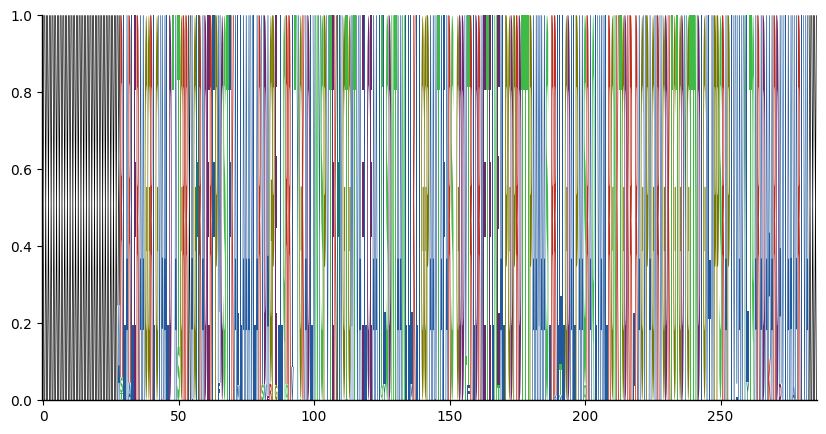

In [ ]:
# Loading BLAT dataset
import torch
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device, outputnonlin=torch.nn.LeakyReLU(0.1))
#deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device, outputnonlin=torch.nn.Sigmoid())
#deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device, outputnonlin=torch.nn.Softmax(dim=-1))

#optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.01, weight_decay=1e-4) #best without dropout

#optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.001, weight_decay=1e-2)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.1)


loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    #import ipdb; ipdb.set_trace()
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")

else:
    #deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 200, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )
    deepseq.training_representation(trainloader =trainloader_pretrainer, 
                                    optimizer = optimizer_deepseq,
                                    n_epochs = 200, 
                                    warmup=1, 
                                    logdir=logdir, 
                                    out_modelname=outmodel_name)


#deepseq(dataset_msa.prot_space)
print('Proceed...')
#import ipdb; ipdb.set_trace()
#plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)

In [25]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()

def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''

        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))

        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs),
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)

                # Calculat loss
                #loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) + beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]
                loss = ( torch.nn.functional.cross_entropy(out[0].permute(0,2,1), 
                                                data.argmax(-1), reduction = "none") + out[7].mean(-1).reshape(-1,1)
                                                + out[8].mean(-1).reshape(-1,1) 
                                                + out[9].mean(-1).reshape(-1,1) ).mean()

                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS
                optimizer.step()


                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())

                # Save to tensorboard
                iteration = epoch*len(trainloader) + i

                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()

        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [ ]:

batch_loss_dict = {}

#logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_29March2024_best_batchsize_100_lr1e_4.pth'
#logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_29March2024_best_batchsize_10_lr1e_4_500iter.pth'
#logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_1April2024_best_batchsize_10_lr1e_5_1000iter.pth'

#logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_17Aug2024_best_batchsize_10_lr1e_5_1000iter.pth'

#logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_5Sept2024_best_batchsize_10_lr1e_5_1000iter_100seqs.pth'
#logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_5Sept2024_best_batchsize_10_lr1e_5_1000iter_200seqs.pth'
#logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_5Sept2024_best_batchsize_10_lr1e_5_1000iter_300seqs.pth'
logdir_density = 'pretrained_densities'; outmodel_name_density = 'trained_density_BLAT_22_preprint_5Sept2024_best_batchsize_10_lr1e_5_1000iter_1000seqs.pth'


pretrained_density = logdir_density + "/" + outmodel_name_density
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid
# the backpropagation of such module during the optimization

"""
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std,
                    latent_dim = args.latent_dim,
                    encoder = get_encoder( args.ed_type.split(",")[0] ),
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    posterior_variance = True,
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-775,775])#[-175,175] [-15,15] ) #[15,15] #if we increase it, major accuracy

#model.get_deepsequence_module(deepseq)

# Optimizer
#best fit for this setup: batch size = 100, lr=1e-4, for betalactamase experiment to see effects upon mutations
opt = torch.optim.AdamW(model.parameters(), lr=1e-5)#, weight_decay=1e-19)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'


if os.path.isfile(pretrained_density):
    print ("Loading Density Model...")
    model.load_state_dict( torch.load(pretrained_density, map_location=casted_device) )
    print ("Loaded")
else:
    fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi
    
    torch.save(model.state_dict(), pretrained_density)
"""



'\nif os.path.isfile(pretrained_density):\n    print ("Loading Density Model...")\n    model.load_state_dict( torch.load(pretrained_density, map_location=casted_device) )\n    print ("Loaded")\nelse:\n    fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir=\'\',\n            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi\n    \n    torch.save(model.state_dict(), pretrained_density)\n'

## DMS Loading data and Mutation Effects Prediction experiment with DeltaELBO

In [ ]:
def load_fasta_dict(file_path):
    fasta_dict = {}
    with open(file_path, 'r') as file:
        sequence_id = ""
        sequence = []
        for line in file:
            line = line.strip()  # Remove any trailing whitespace
            if line.startswith(">"):
                if sequence_id:
                    # Add the previous sequence to the dictionary
                    fasta_dict[sequence_id] = ''.join(sequence)
                # Extract the UniProt ID (the part after '>' and before the first space)
                sequence_id = line[1:].split()[0]
                sequence = []  # Reset sequence for new ID
            else:
                # Accumulate sequence lines
                sequence.append(line)
        # Add the last sequence to the dictionary
        if sequence_id:
            fasta_dict[sequence_id] = ''.join(sequence)
    return fasta_dict

def reorder_dict(reference_dict, dict_to_reorder):
    """
    Reorder the keys in dict_to_reorder to match the order of keys in reference_dict.

    Args:
        reference_dict (dict): The reference dictionary whose order of keys is to be followed.
        dict_to_reorder (dict): The dictionary that needs to be reordered.

    Returns:
        dict: A new dictionary with keys ordered according to reference_dict.
    """
    reordered_dict = {}
    for key in reference_dict:
        if key in dict_to_reorder:
            reordered_dict[key] = dict_to_reorder[key]
        else:
            print(f"Warning: Key {key} found in reference_dict but not in dict_to_reorder.")
    return reordered_dict


#BLAT500_unaligned = load_fasta_dict('../data/set_preprint/BLAT500_ProteinGym_gapsAug2024.fasta')
#BLAT500_aligned = load_fasta_dict('../data/set_preprint/BLAT500_alignment_ProteinGymAug2024.fasta')


print('Ok')



In [ ]:
import pandas as pd

def create_dataframe(lists, names_order):
    # Create a dictionary with each list as a column
    data = { item[1]:item[0] for item in zip(lists,names_order) }
    # Create DataFrame from the dictionary
    df = pd.DataFrame(data)
    return df

def save_to_txt(df, filename):
    # Save DataFrame to a txt file (tab-separated)
    df.to_csv(filename, sep='\t', index=False)


def load_DMS_data(file_path):
    df = pd.read_csv(file_path)
    return df
    
def replacing_wt_2_variant(alphabet, DMS_ref):
    c2i, i2c, i2i = seqsReader._predefine_encoding(alphabet)

    variant_numeric = torch.stack(seqsReader.seq2num(DMS_ref,c2i, i2c, i2i))
    wt_variant = torch.stack([ F.one_hot(variant_numeric[i], len(alphabet)) for i in range(0,variant_numeric.shape[0]) ])
    return wt_variant.permute(1,0,2)

def seq2num(seqs,c2i):
    return [ torch.from_numpy(np.array([ c2i[elem] for elem in seq ])) for seq in seqs ]

def get_elbos(model, wt, mutants, ensemble_count, split=100, aux=None):
    model.eval()

    import ipdb; ipdb.set_trace()
    with torch.no_grad():
        acc_m_elbo = 0
        acc_wt_elbo = 0

        batch = torch.cat([wt.unsqueeze(0), mutants])
        block_batchs = torch.split(batch.float(), split)

        
        for i in range(ensemble_count):

            tmp_res_m = []
            tmp_res_wt = []
            tmp_elbos_block = []

            print('iter {}....\n'.format(i))
            for ii in tqdm(block_batchs, "processing batch.."):
                #import ipdb; ipdb.set_trace()
                if model.__class__.__name__=='DeepSequence': 
                    out_batch = model(ii)
                else:
                    out_batch = model(ii, aux, eq_samples=1, iw_samples=1, switch=1)

                elbos_block = model.get_elbo(ii, out_batch, reduction='none')
                tmp_elbos_block.append(elbos_block.reshape(-1,1))
                #tmp_elbos_block.append(elbos_block.sum(-1).reshape(-1,1)) #for ones without D.Independent distributions or without i.i.e samples
                #tmp_elbos_block.append(elbos_block)

            elbos = torch.vstack(tmp_elbos_block)
            wt_elbo = elbos[0]
            m_elbo = elbos[1:]

            acc_m_elbo += m_elbo
            acc_wt_elbo += wt_elbo

        import ipdb; ipdb.set_trace()
        mutants_logp = acc_m_elbo / ensemble_count
        wt_logp = acc_wt_elbo / ensemble_count
        deltaELBO = mutants_logp - wt_logp

    #import ipdb; ipdb.set_trace()
    return mutants_logp, wt_logp, deltaELBO


def truncate_sequences(df: pd.DataFrame, start_pos: int = 23) -> pd.DataFrame:
    import ipdb; ipdb.set_trace()

    """
    Truncate each sequence in the 'mutated_sequence' column from the specified start position onward.

    :param df: The input DataFrame containing the mutated sequences.
    :param start_pos: The position from which to start truncating the sequence (0-based index).
    :return: A DataFrame with truncated sequences.
    """
    df['truncated_sequence'] = df['mutated_sequence'].apply(lambda seq: seq[start_pos:])
    return df['truncated_sequence']



DMS_data_path = '../data/set_preprint/DMS_Data/BLAT_ECOLX_Stiffler_2015.csv'
output_results_test5 = 'Final_Results_test5.tex'


df_DMS = load_DMS_data(DMS_data_path)
# This chunk of code is just to cut the remaining parts of the wild type in order to adapted to the set if
#  sequences in which I trained, i.e. wild type is the same used in the DMS data, but excepting the 23 first aas

df_DMS['mutated_sequence'] = truncate_sequences(df_DMS)

DMSeq_tensor_numeric = torch.stack(seq2num(df_DMS.mutated_sequence.tolist(),c2i))
mutants_onehot = torch.stack([ F.one_hot(DMSeq_tensor_numeric[i], len(alphabets)) 
                                   for i in range(0,DMSeq_tensor_numeric.shape[0]) ]).to(casted_device)


wt_onehot = dataset_aligned_msa.prot_space[0].to(casted_device)

mutants_logp, wt_logp, deltaELBO = get_elbos(deepseq, wt_onehot.float(), mutants_onehot.float(), ensemble_count=700)

#ensembles =20
#print('{} iterations'.format(ensembles))
#mutants_logp_our, wt_logp_our, deltaELBO_our = get_elbos(model, wt_onehot.float(), mutants_onehot.float(), ensemble_count=ensembles, split=10, aux = deepseq)


from scipy.stats import spearmanr
print(spearmanr(-deltaELBO.detach().cpu().numpy(), df_DMS['DMS_score']))
#print(spearmanr(-deltaELBO_our.detach().cpu().numpy(), df_DMS['DMS_score']))


print(df_DMS)



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/bdb.py", line 334, in set_trace
    sys.settrace(self.trace_dispatch)



> /tmp/ipykernel_483635/974852052.py(79)truncate_sequences()
     78     """
---> 79     df['truncated_sequence'] = df['mutated_sequence'].apply(lambda seq: seq[start_pos:])
     80     return df




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/bdb.py", line 359, in set_quit
    sys.settrace(None)



## --------------------------------------------------------------------